In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
from statistics import mean
from scipy.optimize import curve_fit
import imageio
from pathlib import Path
import warnings

In [9]:
file_path = '/Users/kirahart/Dropbox/jul072021/calibration/'
name = "80C.h5"
name_dark = '/Users/kirahart/Dropbox/jul072021/calibration/dark.h5'

In [10]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

mask = create_circular_mask(256, 320,radius = 100,center = (256/2+50,320/2-40));

In [11]:
hf = h5py.File(file_path+name, 'r')
hfdark = h5py.File(name_dark, 'r')
imgs = np.array(hf['imgs'])
ts  = np.array(hf['temps'])
ans = np.array(hf['set_angels'])
dark = np.array(hfdark['imgs'])

ims = []
Ts = []
for i in range(len(imgs)):
    img_mask = (imgs[i]-dark[i]+.001)*mask 
    img_mask[img_mask == 0] = 'nan' 
    ims.append(img_mask)
    imgs[i] = imgs[i]-dark[i]
    
   
S0 = np.sum(imgs,axis = 0)/2
S1 = imgs[0]-imgs[2]
S2 = imgs[1]-imgs[3]


s1 = S1/S0
s2 = S2/S0

In [12]:
vmx= np.median(S0[100:150,100:150])/1.5

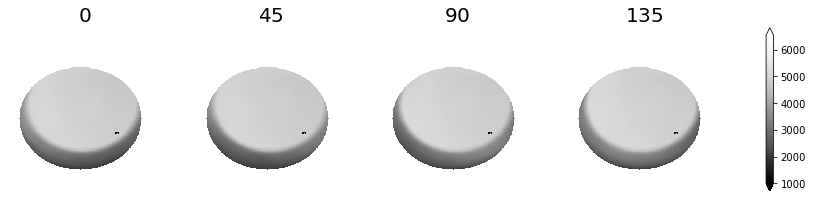

[33.4 33.4 33.4 33.4]


In [13]:
fig, axes = plt.subplots(figsize=(16, 3), ncols=4)
# STOKES IMAGES
# color "mappable" object returned by ax1.imshow
pos1 = axes[0].imshow(np.transpose(ims[0]), cmap='Greys_r', interpolation='none',vmin=1000, vmax=vmx, aspect='auto')
#fig.colorbar(pos1, ax=ax1,extend='both',label = "ADU")
axes[0].set_title("$0$",fontsize = 20)
axes[0].axis('off')
    
pos2 = axes[1].imshow(np.transpose(ims[1]), cmap='Greys_r', interpolation='none',vmin=1000, vmax=vmx, aspect='auto')
#fig.colorbar(pos2, ax=ax2,extend='both')
axes[1].set_title("$45$",fontsize = 20)
axes[1].axis('off')

pos3 = axes[2].imshow(np.transpose(ims[2]), cmap='Greys_r', interpolation='none',vmin=1000, vmax=vmx, aspect='auto')
#fig.colorbar(pos3, ax=ax3,extend='both')
axes[2].set_title("$90$",fontsize = 20)
axes[2].axis('off')

pos4 = axes[3].imshow(np.transpose(ims[3]), cmap='Greys_r', interpolation='none',vmin=1000, vmax=vmx, aspect='auto')
axes[3].set_title("$135$",fontsize = 20)
axes[3].axis('off')

fig.colorbar(pos1, ax=axes.ravel().tolist(), extend='both')

plt.show()

print(ts)

In [15]:
IMGS = []
S0s = []
S1s =[]
S2s = []
temps = [25,30,35,40,45,50,55,60,65,70,75,80];
for i in temps:
    name = str(i)+"C.h5"
    hf = h5py.File(file_path+name, 'r')
    imgs = np.array(hf['imgs'])
    ts  = np.array(hf['temps'])
    ans = np.array(hf['set_angels'])
    dark = np.array(hfdark['dark'])
    Ts.append(np.mean(ts))


    for i in range(len(imgs)):
        imgs[i] = imgs[i] - dark[i]

    imgs[imgs < 0] = np.mean(imgs)

    S0 = imgs[0]#np.sum(imgs,axis = 0)/2
    S1 = imgs[0]-imgs[2]
    S2 = imgs[1]-imgs[3]

    IMGS.append(np.ndarray.flatten(imgs[100:150,150:200]))
    S0s.append(np.ndarray.flatten(S0[100:150,150:200]))
    S1s.append(np.ndarray.flatten(S1[100:150,150:200]))
    S2s.append(np.ndarray.flatten(S2[100:150,150:200]))

In [16]:
def func(x, a, b):
    return a *  x + b

def func1(x, a, b, c):
    return a*(x)**c +b

In [17]:
popt1, pcov1 = curve_fit(func, temps, data)
popt2, pcov2 = curve_fit(func1, temps, data)

NameError: name 'data' is not defined

In [18]:
from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

plt.plot(np.linspace(20,90)+273.0, func(np.double(np.linspace(20,90)), *popt1), 'r-', linewidth = 2 , label = '$\gamma \propto T$')
plt.plot(np.linspace(20,90)+273.0, func1(np.double(np.linspace(20,90)), *popt2), 'b-', linewidth= 2 , label = '$\gamma \propto T^4$')
plt.legend(fontsize = 14)
plt.plot(np.add(temps,273.0),data, 'k.',markersize = 14,label = 'data')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Scene Temperature [K]',fontsize = 14)
plt.ylabel('$\gamma$(T)  [ADU]',fontsize = 14)
plt.grid(True)
plt.show()


NameError: name 'popt1' is not defined

## plt.plot(temps, data- func(np.double(temps), *popt1), 'r.')
plt.plot(temps, data-func1(np.double(temps), *popt2), 'b.')

In [371]:
def nrmse(data,fit):
    er = data -fit
    err = np.sqrt(np.mean(er**2))
    ymax = np.max(data)
    ymin = np.min(data)
    return 100*err/(ymax-ymin)


In [372]:
s0 = np.transpose(S0s)

e1 = []
e2 = []

for i in range(len(S0s)):
    data = s0[i]
    
    [a1,b1], pcov1 = curve_fit(func, temps, data)
    [a2,b2,c2], pcov2 = curve_fit(func1, temps, data)
    
    fit1=func(np.double(np.linspace(25,80,12)), *popt1)
    fit2=func1(np.double(np.linspace(25,80,12)), *popt2)
    
    err1 = nrmse(data,fit1)
    err2 = nrmse(data,fit2)
    
    e1.append(err1)
    e2.append(err2)

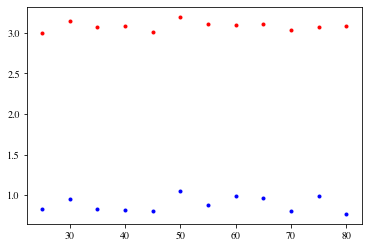

In [373]:
plt.plot(temps,e1, 'r.', linewidth = 2 , label = '$\gamma \propto T$')
plt.plot(temps,e2, 'b.', linewidth= 2 , label = '$\gamma \propto T^4$')


In [374]:

T = 30; 
delta = 1
response = 1e5
temps = np.linspace(10,80,100)
srnedt = np.zeros(len(temps))

for i in range(len(temps)):
    delta = 20
    response = 1e5
    snr = snrs[0]
    t = temps[i]
    while response > snr:
        response = func1(t+delta/2, *popt2)-func1(t-delta/2, *popt2)
        delta = delta -.01
    
    srnedt[i] = delta

In [375]:
snrs = np.mean(S0s,axis = 1)/np.std(S0s,axis = 1)

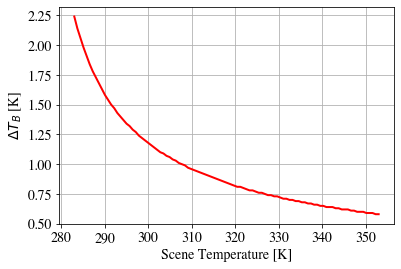

In [365]:
plt.plot(temps+273,srnedt, 'r-', linewidth = 2 )
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Scene Temperature [K]',fontsize = 14)
plt.ylabel('$\Delta T_B$ [K]',fontsize = 14)
plt.grid(True)
plt.show()

In [396]:
popt2

array([   2.3413371 , 1068.39597815,    1.66214423])

In [5]:
pwd

'/Users/kirahart/Dropbox/GitHub/IRCSP/data_reduction/IRCAM'